# Importing all the necessary Libraries


In [38]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

# Visualising the dataset

Visualizing a random image using Heat Maps.

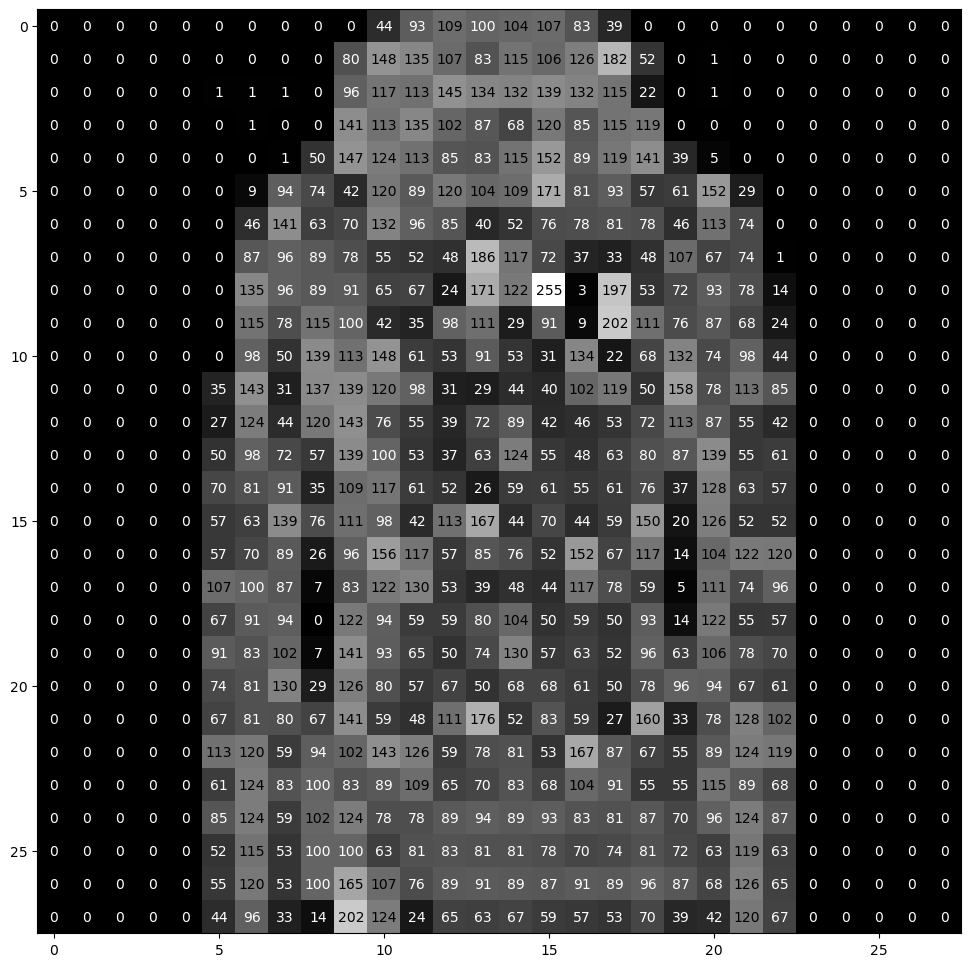

In [50]:
(training, _), (_, _) = fashion_mnist.load_data()

X_train = training/ 127.5-1
X_train = np.expand_dims(X_train, axis=3)   #Rescaling the data to [-1,1]

def visualize_input(img, ax):
    ax.imshow(img, cmap= 'gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy = (y, x),
                        horizontalalignment = 'center',
                        verticalalignment = 'center',
                        color = 'white' if img[x][y] < thresh else 'black')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
visualize_input(training[4500], ax)


# Building the generator

At first, I used a system of Transposed Convolutional Layers for the architecture of the generator. But the convolutional layers just weren't working. I don't know the reason yet and I'd love to be educated. 

Then, I changed the architecture to multiple Dense layers with LeakyRelu as the activation and Batch Normalizing in between layers.

In [40]:
def build_generator():
    generator = Sequential()
    
    # generator.add(Dense(128 * 7 * 7, activation = 'relu', input_dim = 100))
    
    # generator.add(Reshape((7, 7, 128)))
    
    # generator.add(UpSampling2D())
    
    # generator.add(Conv2DTranspose(1024, kernel_size=3, padding='same', activation='relu'))
    # generator.add(BatchNormalization(momentum=0.8))
    # generator.add(UpSampling2D())
    
    # generator.add(Conv2DTranspose(512, kernel_size=3, padding='same', activation='relu'))
    # generator.add(BatchNormalization(momentum=0.8))
    
    
    # generator.add(Conv2DTranspose(256, kernel_size=3, padding='same', activation='relu'))
    # generator.add(BatchNormalization(momentum=0.8))
    
    # generator.add(Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))
    # generator.add(BatchNormalization(momentum=0.8))
    
    # generator.add(Conv2DTranspose(1, kernel_size=3, padding='same', activation='relu'))
    
    generator.add(Dense(512, input_shape=[100]))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))
    
    generator.add(Dense(256, input_shape=[100]))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))
    
    generator.add(Dense(256, input_shape=[100]))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))
    
    generator.add(Dense(784))
    
    generator.add(Reshape([28,28,1]))
    
    generator.summary()
    
    noise = Input(shape=(100,))
    
    fake_image = generator(noise)
    
    return Model(inputs=noise, outputs=fake_image)
    

# Building the Discriminator

I used a series of Convolutional Layers for the Discriminator. The model Structure is as given Below

Conv -> Leakyrelu -> Dropout -> Conv -> ZeroPadding -> Batch Normalization -> Leakyrelu -> Dropout -> Conv -> ZeroPadding -> Batch Normalization -> Leakyrelu -> Dropout -> Conv -> ZeroPadding -> Batch Normalization -> Leakyrelu -> Dropout -> Flatten -> Dense -> Sigmoid

But as I mention in the comment in the code below, The Discriminator was too strong for the Generator, So I had to remove some layers to reduce the complexity of the Discriminator

Reduced Model:
Conv -> Leakyrelu -> Dropout  -> Flatten -> Dense -> Sigmoid

In [41]:
def build_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    
    # discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    # discriminator.add(ZeroPadding2D(padding = ((0,1),(0,1))))
    # discriminator.add(BatchNormalization(momentum = 0.8))
    
    # discriminator.add(LeakyReLU(alpha=0.2))
    # discriminator.add(Dropout(0.25))
    
    # discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    # discriminator.add(BatchNormalization(momentum=0.8))
    # discriminator.add(LeakyReLU(alpha=0.2))
    # discriminator.add(Dropout(0.25))    
    
    # discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
    # discriminator.add(BatchNormalization(momentum=0.8))
    # discriminator.add(LeakyReLU(alpha=0.2))
    # discriminator.add(Dropout(0.25))  
    
    # I commented all these layers because the Discriminator was too strong for the generator otherwise
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    
    img = Input(shape=(28,28,1))
    probability = discriminator(img)
    return Model(inputs=img, outputs=probability)

# Building the Combined Model

I made a combined model to train the Generator. I used Adam as the optimizer with learning rate 0.001 and 0.01 for the discriminator and the generator respectively. At first, I used the same learning rate for both of the models but as it turns out the Generator was still learning too slow when compared with the Discriminator. 
I changed the learning rates and made the discriminator learn slower than the Generator. After a lot of tuning I came down to these values as they were generating acceptable results.


In [42]:
optimizer_discriminator = Adam(learning_rate=0.001, beta_1=0.5)
optimizer_combined = Adam(learning_rate=0.01, beta_1=0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_discriminator, metrics=['accuracy'])

discriminator.trainable = False

generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

valid = discriminator(img)

combined = Model(inputs = z, outputs = valid)
combined.compile(loss='binary_crossentropy', optimizer = optimizer_combined)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 512)               51712     
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_35 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_36 (Bat  (None, 256)              1024      
 chNormalization)                                    

## Plotting function

I just wrote this function to print out the output images while training.

In [43]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples,100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

# Building the training function 

Training function for GAN works similarly. I'll break it down it simple terms.

Step 1->

You tell the generator to generate a image by giving it a noise vector (just random canvas to play around with).

Step 2->

You give the image to the discriminator and tell it to discriminate the image and classify if the image is generated or from the original dataset. The discriminator gives a confidence value of how likely the image is to be of the original dataset.

Step 3->

The discriminator is told how wrong or right it was. (Discriminator is Trained)
After discriminator is trained we tell the Generator that the dicriminator was this right which is the same as the generator being wrong. (Generator is Trained)

Step 4->

These steps are repeated for an amount of time. And the Discriminator and the Generator compete with each other, making themselves better at their job in the process. 

In [44]:
def train(epochs, batch_size=128, save_interval=50):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        noise = np.random.normal(size=[batch_size, 100])
        gen_imgs = generator.predict_on_batch(noise)
        
        
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        
        discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, valid)
        
        print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch % save_interval == 0 or epoch in [10,100]:
            plot_generated_images(epoch, generator)

# Training

Below you can see the Training and after Training you can see the Generator's progress after 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000 and 9000 epochs.

2023-03-25 11:19:13.184281: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_27/sequential_18/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-25 11:19:16.097467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_29/model_27/sequential_18/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


0 [D loss: 0.728073, acc: 12.50%] [G loss: 0.614512]
4/4 [==============================] - 0s 9ms/step
1 [D loss: 0.619067, acc: 53.12%] [G loss: 0.465628]
2 [D loss: 0.737566, acc: 50.00%] [G loss: 0.247324]
3 [D loss: 1.351698, acc: 50.00%] [G loss: 0.312581]
4 [D loss: 1.413482, acc: 68.75%] [G loss: 0.918505]
5 [D loss: 1.157897, acc: 75.00%] [G loss: 2.506705]
6 [D loss: 0.412515, acc: 90.62%] [G loss: 1.335937]
7 [D loss: 1.285526, acc: 71.88%] [G loss: 2.511002]
8 [D loss: 0.888778, acc: 68.75%] [G loss: 3.417652]
9 [D loss: 0.434699, acc: 81.25%] [G loss: 3.729686]
10 [D loss: 0.354662, acc: 87.50%] [G loss: 2.710478]
4/4 [==============================] - 0s 15ms/step
11 [D loss: 0.469845, acc: 78.12%] [G loss: 2.017576]
12 [D loss: 1.444808, acc: 62.50%] [G loss: 2.968176]
13 [D loss: 1.570426, acc: 59.38%] [G loss: 3.653882]
14 [D loss: 0.765761, acc: 56.25%] [G loss: 3.144835]
15 [D loss: 0.551825, acc: 53.12%] [G loss: 2.570116]
16 [D loss: 0.619613, acc: 50.00%] [G loss:

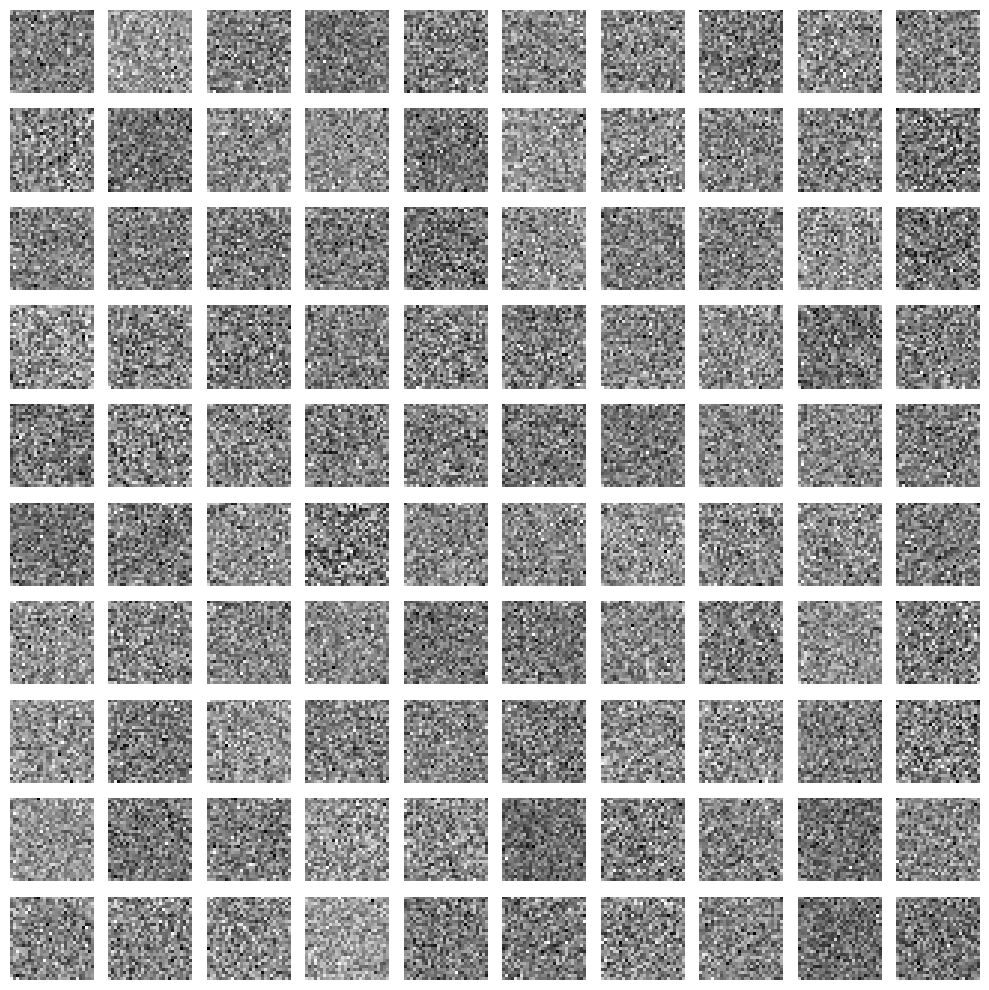

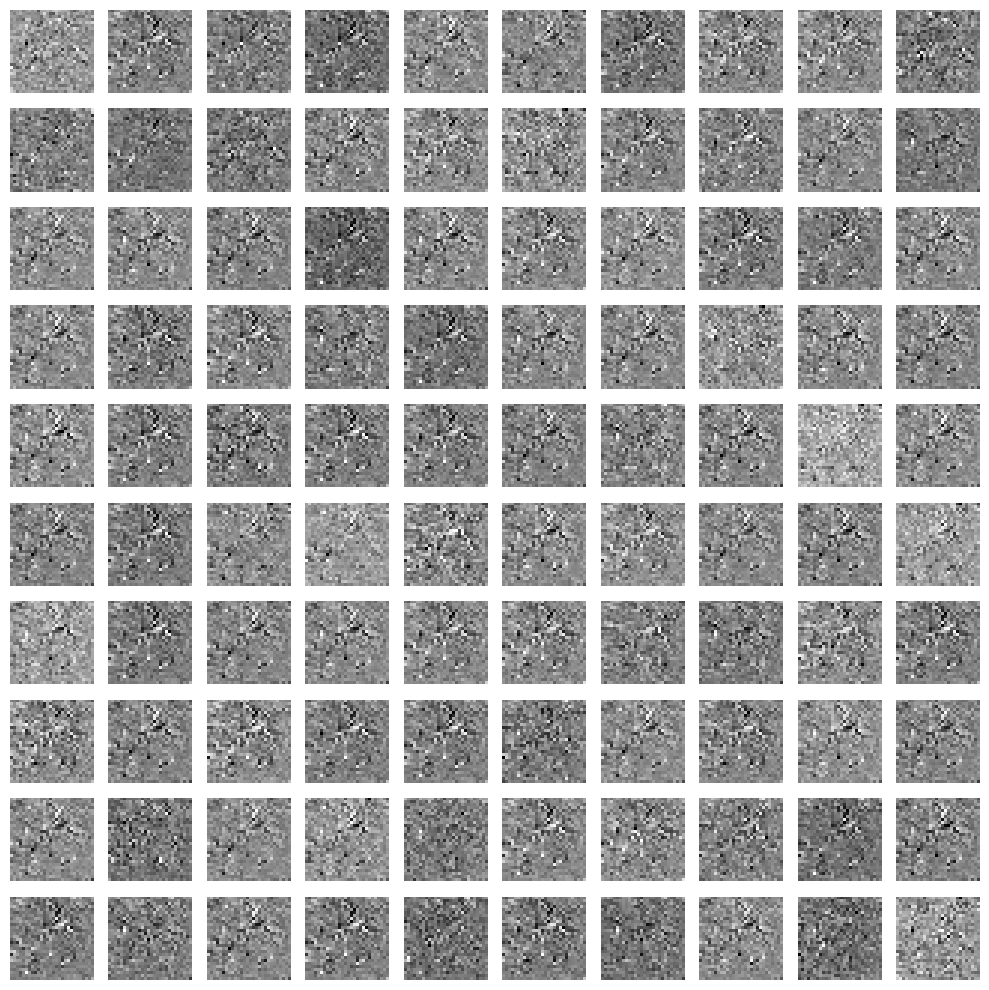

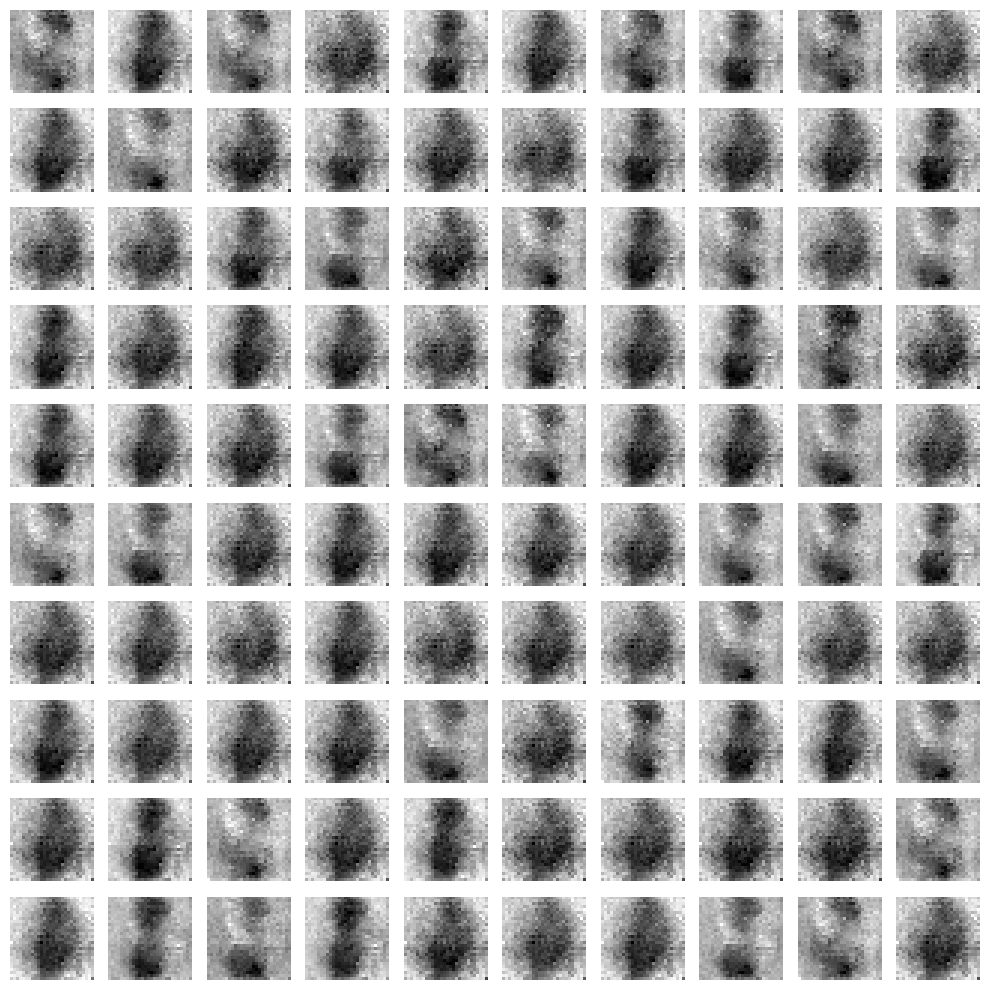

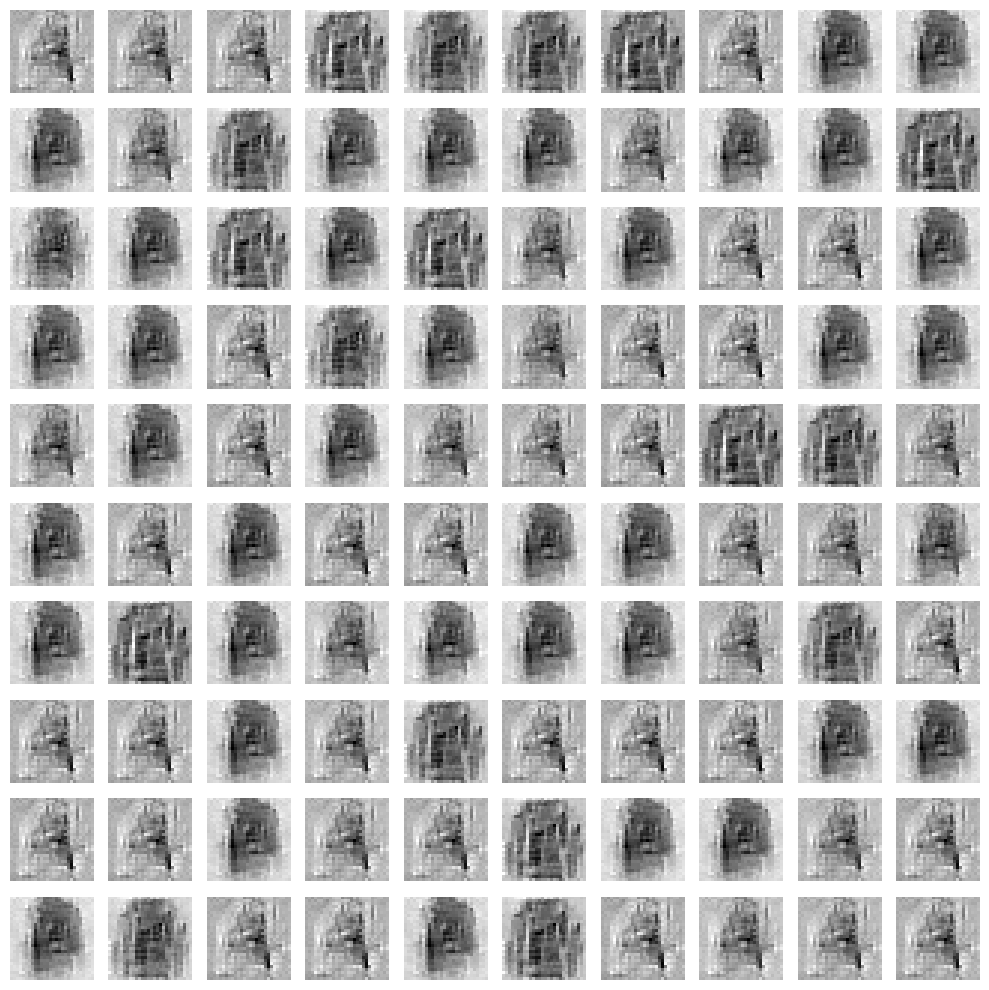

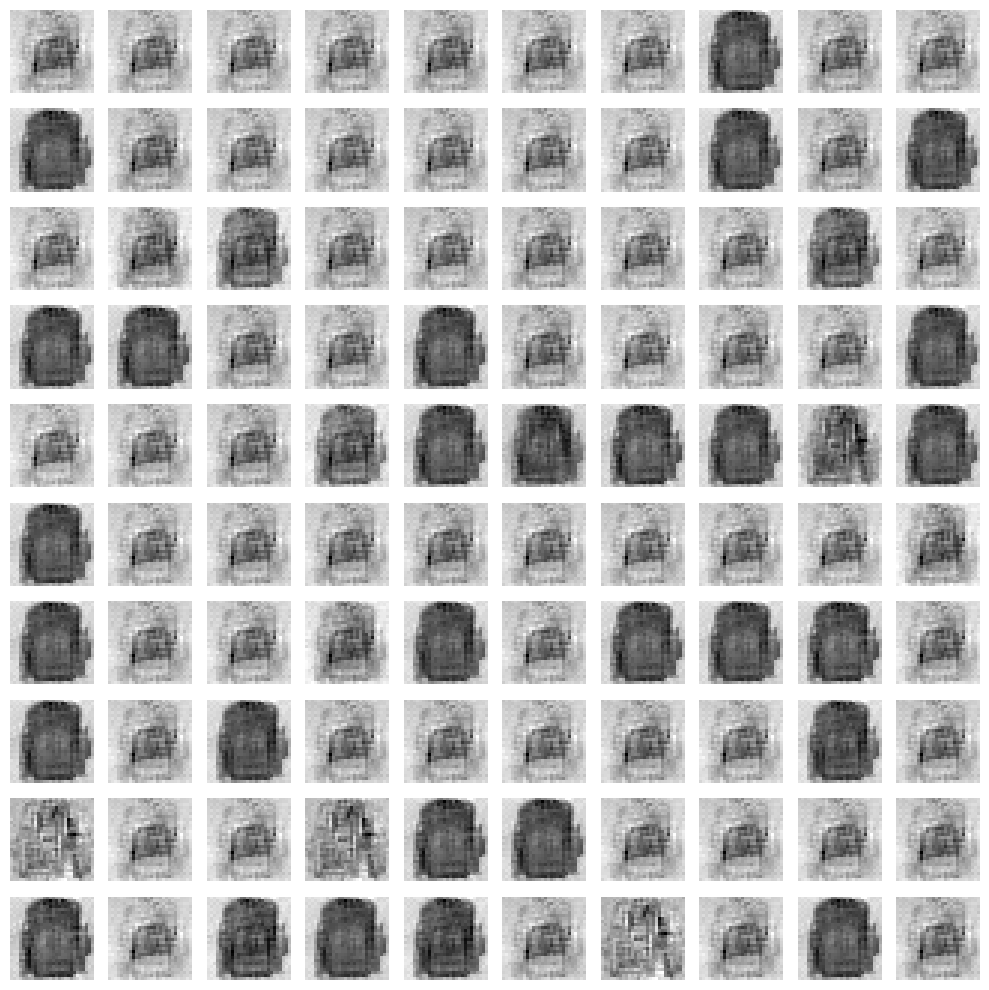

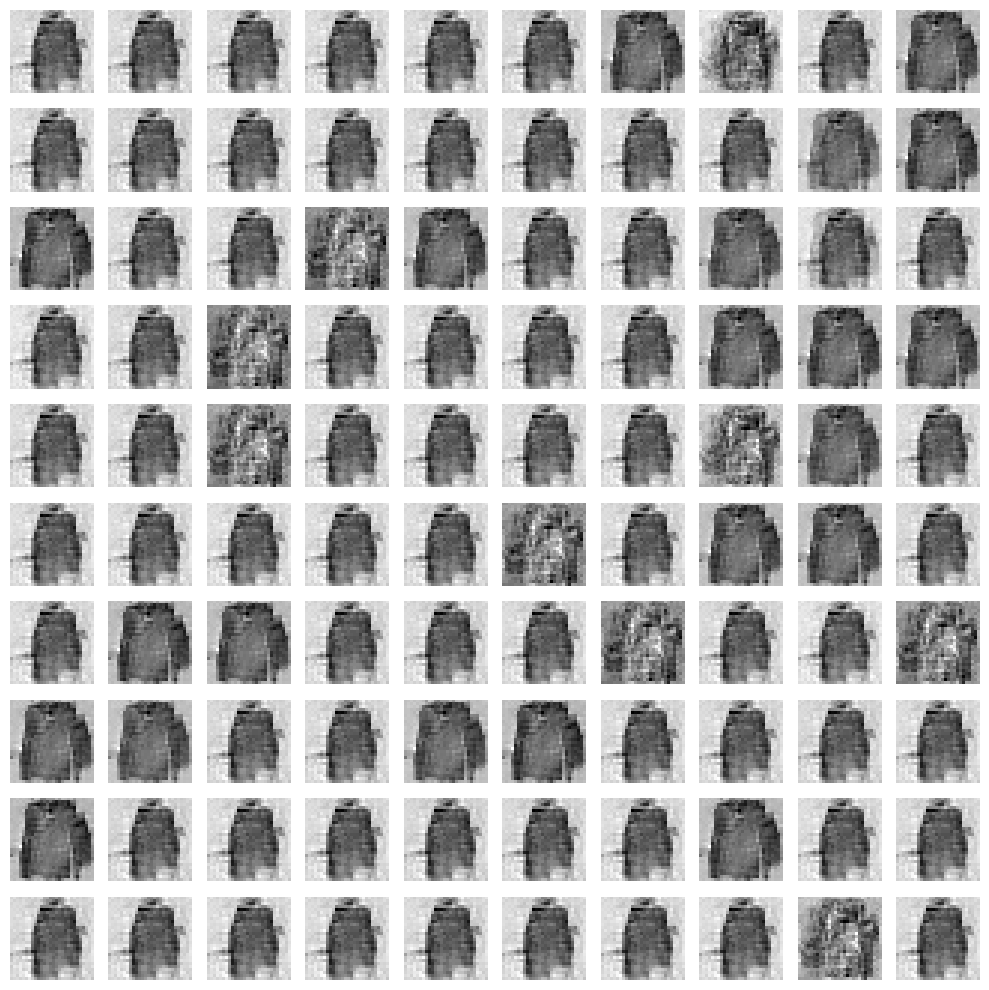

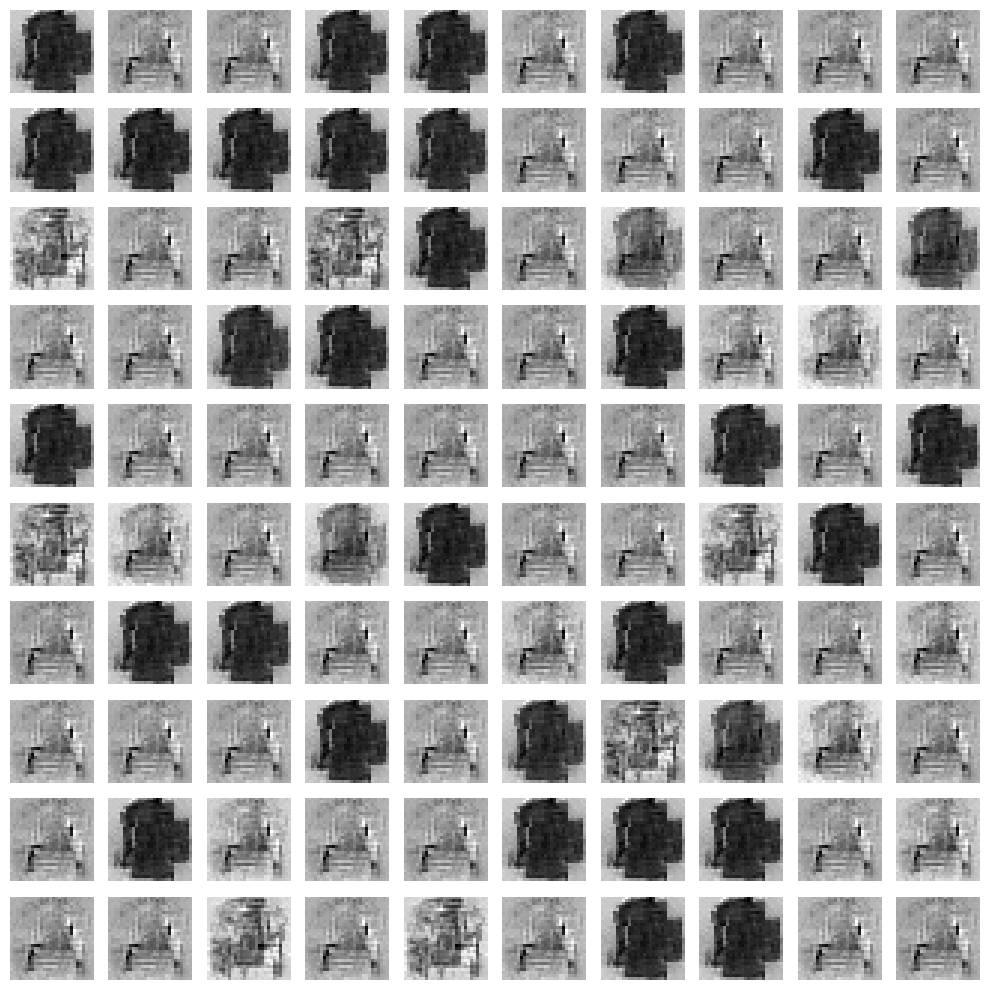

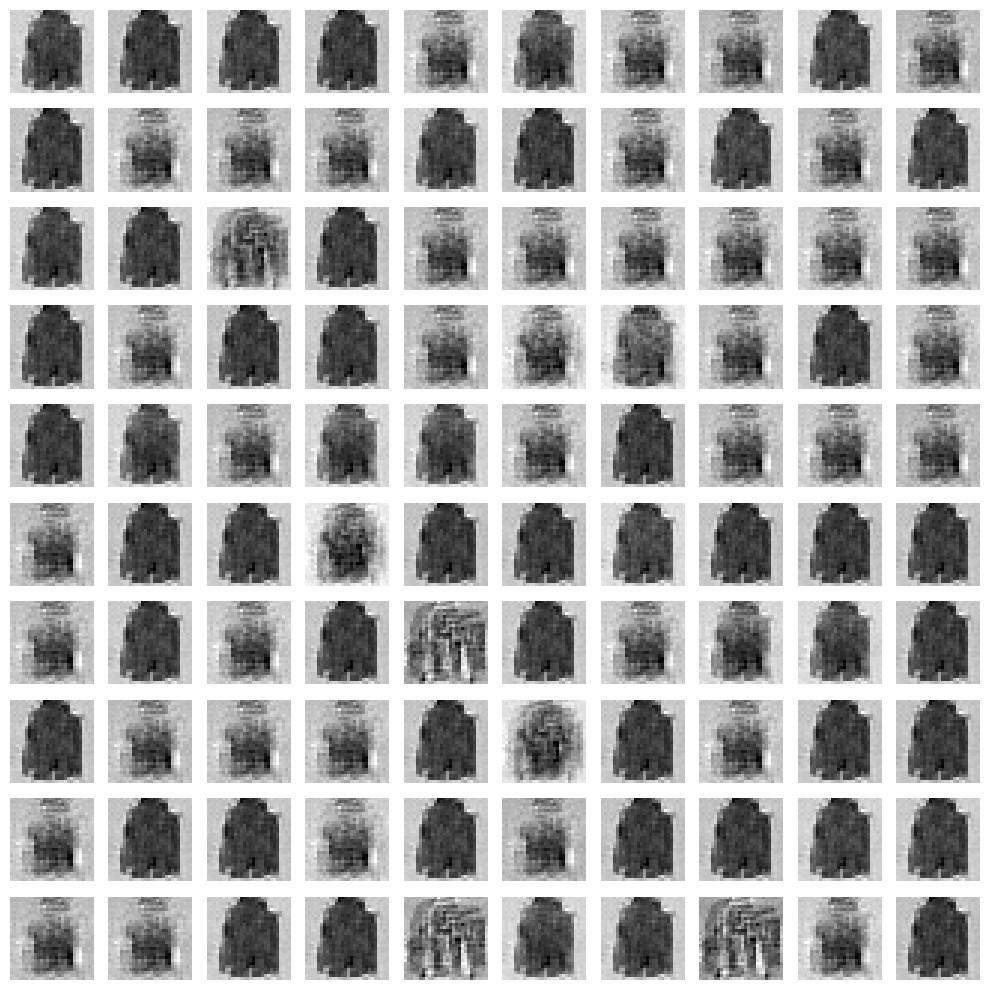

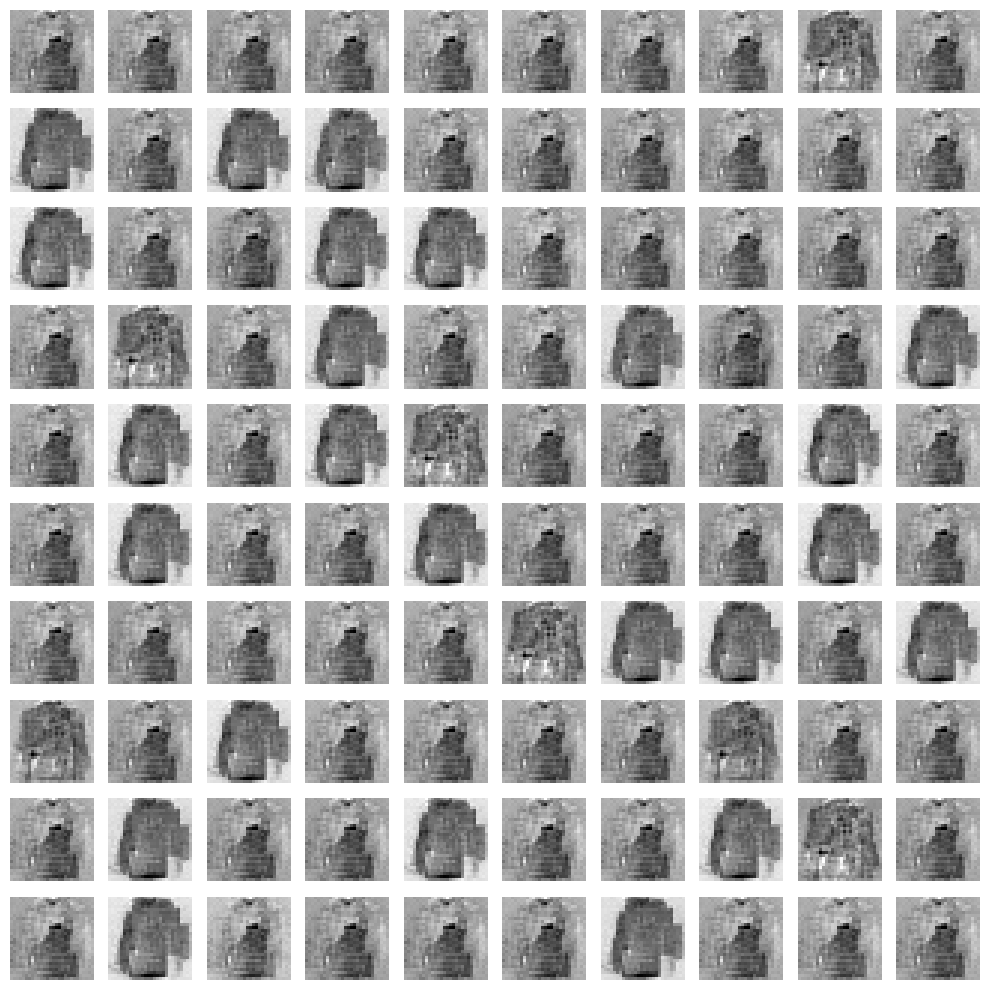

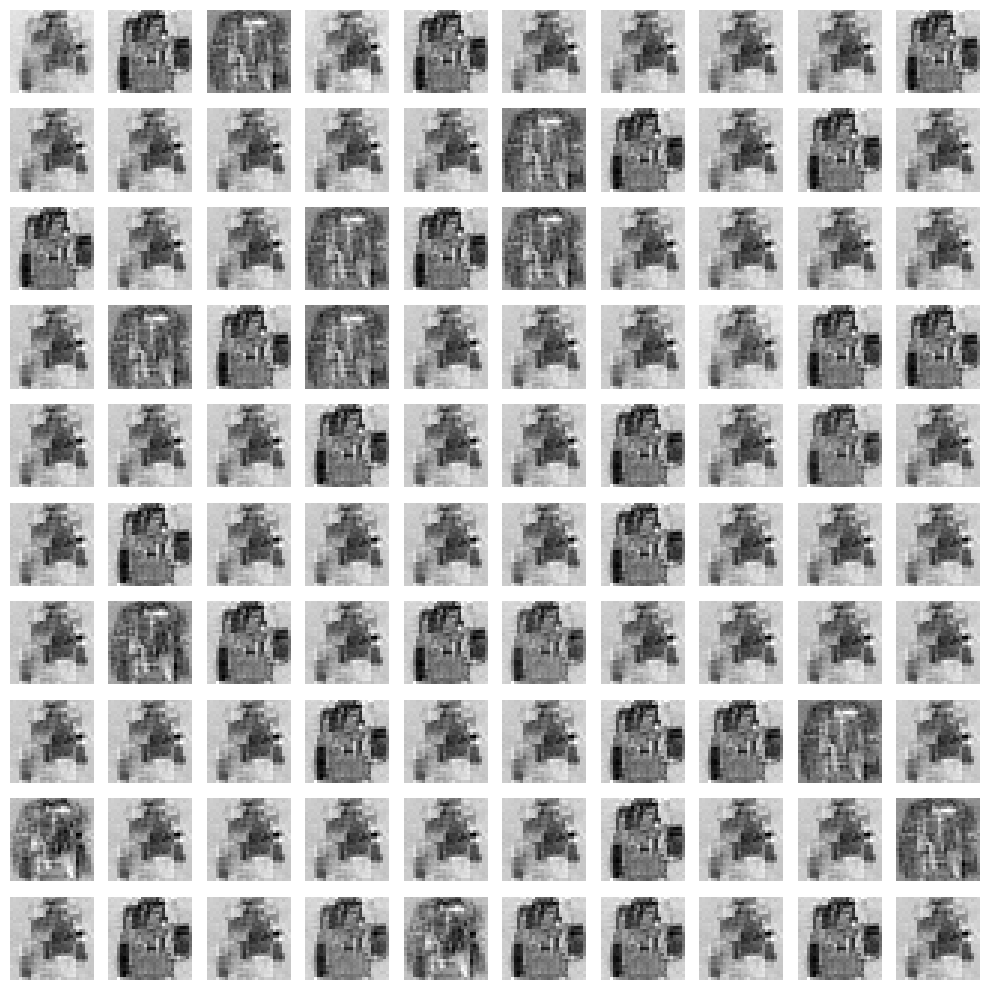

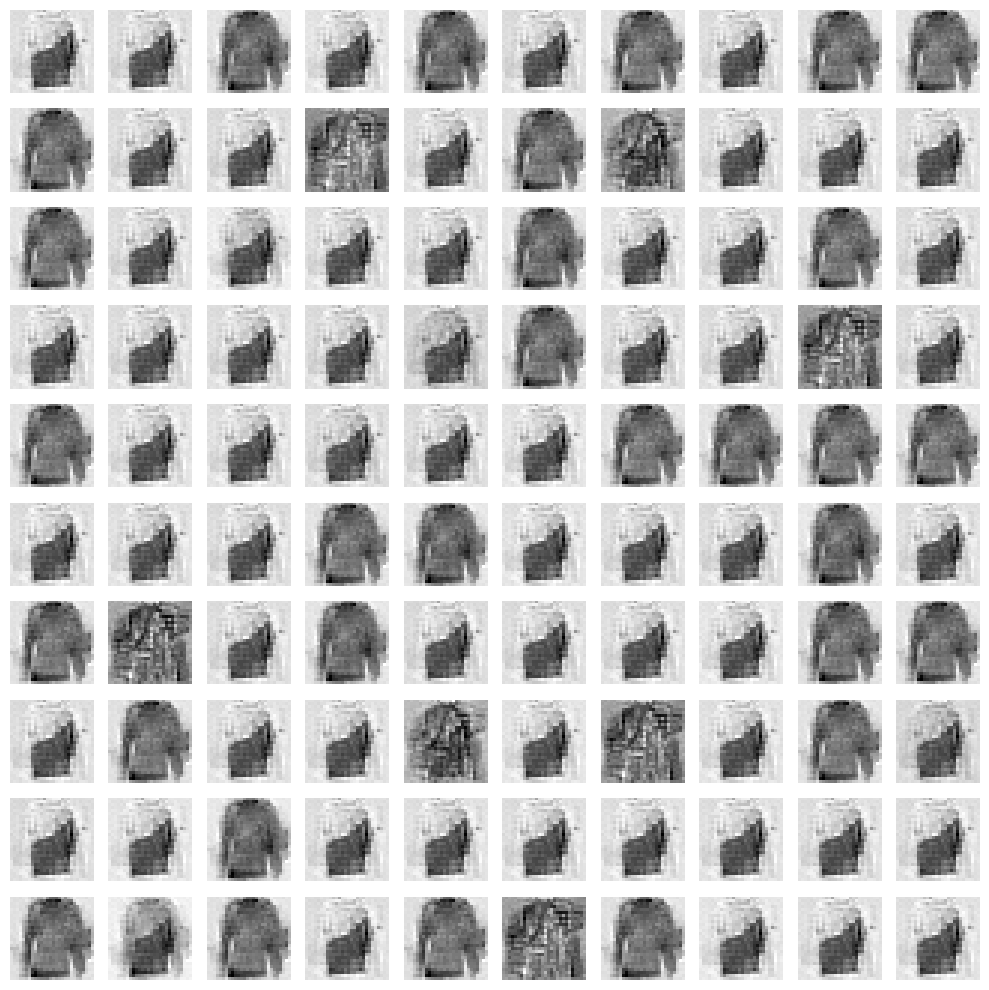

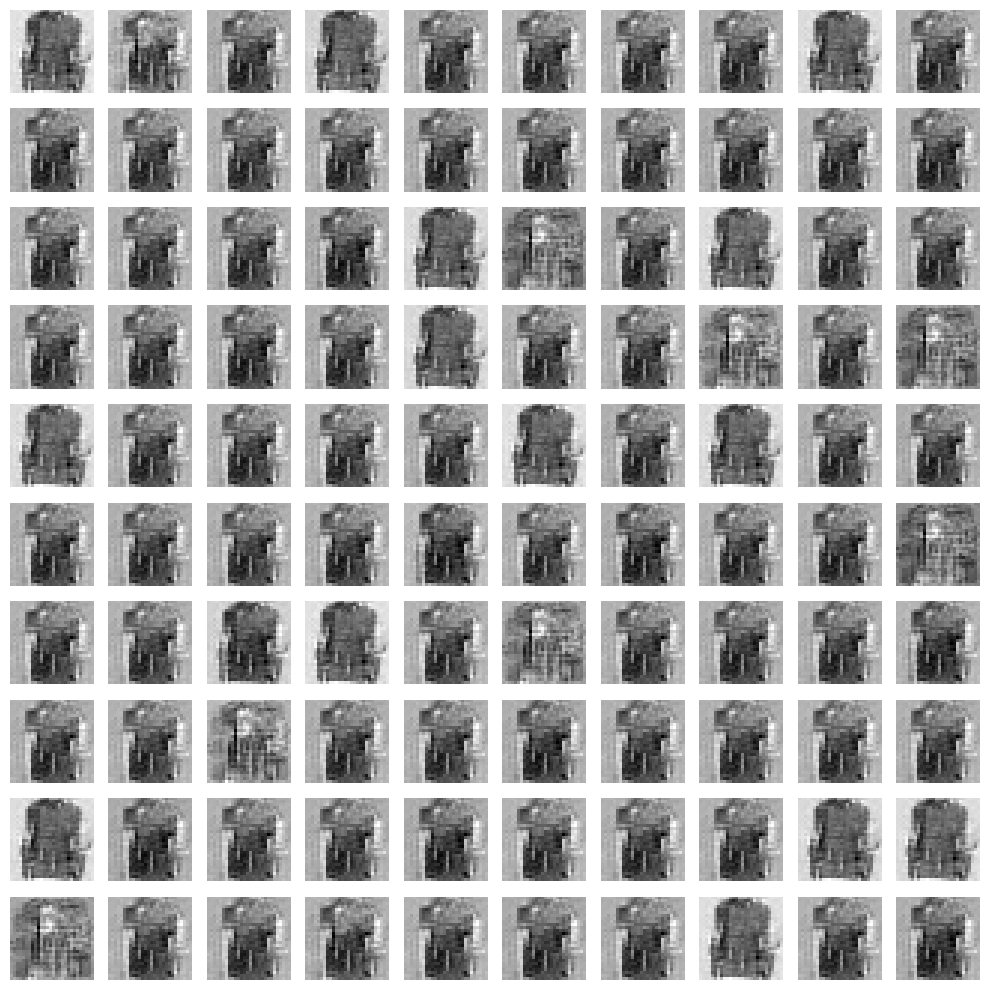

In [45]:
train(epochs=10000, batch_size=16, save_interval=1000)

# Final Result

After training for 10,000 epochs the Model was able to generate pretty convincing images as you can see below. 

4/4 [==============================] - 0s 10ms/step


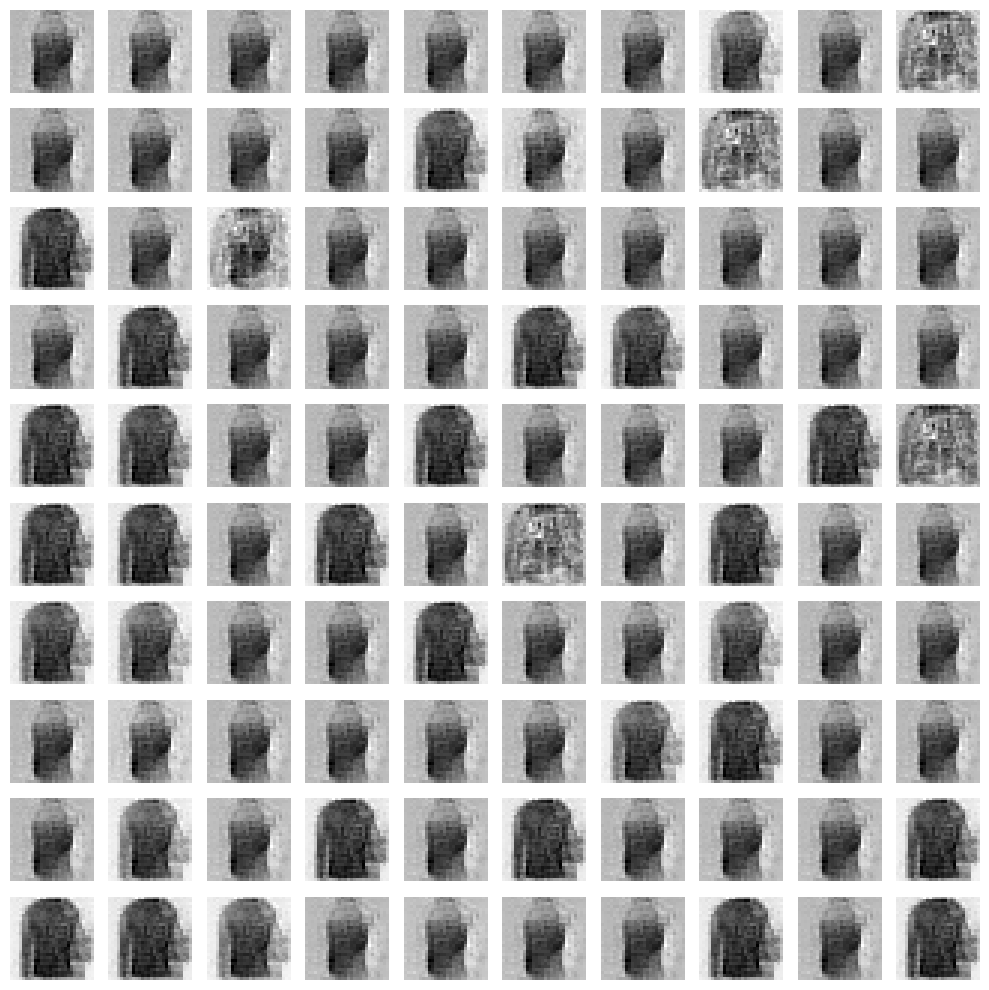

In [48]:
plot_generated_images(1,generator)